In [212]:
import numpy as np
from scipy.integrate import solve_ivp

import sympy as sp
from sympy.physics.mechanics import dynamicsymbols, init_vprinting

init_vprinting()

<img src="pendulum_sketch.png" alt="pendulum" width="300"/>

$$
x_{m_1} = \ell_1 \sin(\theta_1)  ~~~~~~~~~~~~~~~~~~~~~~~ y_{m_1} = - \ell_1 cos(\theta_1)
\newline
\dot x_{m_1} = \ell_1 \dot \theta_1 cos(\theta_1) ~~~~~~~~~~~~~~~~~~~~~~~ \dot y_{m_1} = \ell_1 \dot \theta_1 (sin \theta_1)
$$

$$
x_{m_2} = \ell_1 \sin(\theta_1) + \ell_2 \sin(\theta_2)  ~~~~~~~~~~~~~~~~~~~~~~~ y_{m_2} = - \ell_1 cos(\theta_1) - \ell_2 cos(\theta_2)
\newline
\dot x_{m_2} = \ell_1 \dot \theta_1 cos(\theta_1) + \ell_2 \dot \theta_2 cos(\theta_2) ~~~~~~~~~~~~~~~~~~~~~~~ \dot y_{m_2} = \ell_1 \dot \theta_1 (sin \theta_1) + \ell_2 \dot \theta_2 (sin \theta_2)
$$

$$
T = \frac{1}{2} m_1 v_1^2 + \frac{1}{2} m_2 v_2^2 ~~~~~~~~~~~~~~~~~~~~~~~ V = m_1 g h_1 + m_2 g h_2
$$

$$
T = \frac{1}{2} m_1 (\dot x_{m_1}^2 + \dot y_{m_1}^2) + \frac{1}{2} m_2 (\dot x_{m_2}^2 + \dot y_{m_2}^2) ~~~~~~~~~~~~~~~~~~~~~~~ V = m_1 g y_{m_1} + m_2 g y_{m_2}
$$

In [69]:
# Create symbolic variables
m_1, m_2, ell_1, ell_2, g, t = sp.symbols('m_1, m_2, ell_1, ell_2, g, t')
theta_1, theta_2 = dynamicsymbols('theta_1, theta_2')

# Define xm1, ym1, xm2, ym2
xm1 = ell_1 * sp.sin(theta_1)
ym1 = -ell_1 * sp.cos(theta_1)
xm2 = xm1 + ell_2 * sp.sin(theta_2)
ym2 = ym1 - ell_2 * sp.cos(theta_2)

# Derivatives of xm1, ym1, xm2, ym2
xm1_dot = sp.diff(xm1, t)
ym1_dot = sp.diff(ym1, t)
xm2_dot = sp.diff(xm2, t)
ym2_dot = sp.diff(ym2, t)

theta_1_dot = sp.diff(theta_1, t)
theta_2_dot = sp.diff(theta_2, t)
theta_1_ddot = sp.diff(theta_1_dot, t)
theta_2_ddot = sp.diff(theta_2_dot, t)

# Lagrangian
T = sp.Rational(1,2) * m_1 * (xm1_dot**2 + ym1_dot**2) + sp.Rational(1,2) * m_2 * (xm2_dot**2 + ym2_dot**2)
V = m_1 * g * ym1 + m_2 * g * ym2

L = T - V

In [164]:
print('Lagrangian:')
L.simplify()

Lagrangian:


$$
p_{\theta_1} = \dfrac{\partial L}{\partial \dot \theta_1}, ~
p_{\theta_2} = \dfrac{\partial L}{\partial \dot \theta_2}
$$

In [71]:
# Canonical Momentum
p_theta_1 = sp.diff(L, theta_1_dot)
p_theta_2 = sp.diff(L, theta_2_dot)

In [72]:
p_theta_1.simplify(), p_theta_2.simplify()

$$
\dfrac{d}{dt} \bigg( \dfrac{\partial L}{\partial \dot q} \bigg) - \dfrac{\partial L}{\partial q} = 0
$$

$$
\dfrac{d}{dt} \bigg( \dfrac{\partial L}{\partial \dot \theta_i} \bigg) - \dfrac{\partial L}{\partial \theta_i} = 0
\implies
\dfrac{d p_{\theta_i}}{dt} - \dfrac{\partial L}{\partial \theta_i} = 0
$$

In [194]:
# Euler-Lagrange Equations
eq1 = sp.Eq(sp.diff(p_theta_1, t) - sp.diff(L, theta_1), 0).simplify()
eq2 = sp.Eq(sp.diff(p_theta_2, t) - sp.diff(L, theta_2), 0).simplify()

In [195]:
eq1, eq2

In [199]:
# Solve Equations
solutions = sp.solve([eq1, eq2], [theta_1_ddot, theta_2_ddot])
solution1 = solutions[theta_1_ddot]
solution2 = solutions[theta_2_ddot]

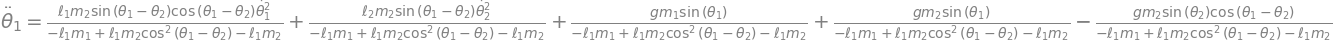

In [200]:
sp.Eq(theta_1_ddot, solution1)

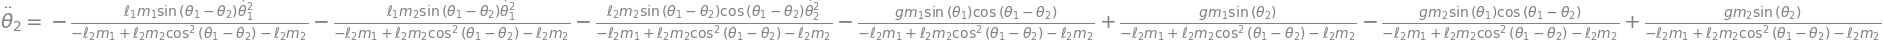

In [201]:
sp.Eq(theta_2_ddot, solution2)

We must decompose the second order ODEs into a system of first order ODEs. Any second order ODE can be split into 2 first order ODEs by defining a new variable as the derivate of the original variable:

$$
\dot \theta_1 = \omega_1 ~~~~~~~~~~~~~~~~~~~~~~~ \dot \theta_2 = \omega_2
$$
$$
\ddot \theta_1 = \dot \omega_1 ~~~~~~~~~~~~~~~~~~~~~~~ \ddot \theta_2 = \dot \omega_2
$$

Now we have 4 first order ODEs:
* $\dot \theta_1 = \omega_1$
* $\dot \theta_2 = \omega_2$
* $\dot \omega_1 = ...$
* $\dot \omega_2 = ...$

Now we convert the **symboilc** equations into **numeric** functions with the sympy function `lamdify()`:

In [202]:
omega_1_dot_f = sp.lambdify((t, g, ell_1, ell_2, m_1, m_2, theta_1, theta_2, theta_1_dot, theta_2_dot), solution1)
omega_2_dot_f = sp.lambdify((t, g, ell_1, ell_2, m_1, m_2, theta_1, theta_2, theta_1_dot, theta_2_dot), solution2)
theta_1_dot_f = sp.lambdify(theta_1_dot, theta_1_dot)
theta_2_dot_f = sp.lambdify(theta_2_dot, theta_2_dot)

We must define $\vec S = [\theta_1, \theta_2, \omega_1, \omega_2]$ which is a vector that's the system of ODEs. To use a differential equation solver, we must define a function that takes $\vec S$ and $t$ as arguments and returns the derivative of $\vec S$ with respect to $t$, $\dfrac{d \vec S}{dt}$ or $\dot{\vec S}$.

In [217]:
def S_dot(t, S, g, ell_1, ell_2, m_1, m_2):
    theta_1, theta_2, omega_1, omega_2 = S
    return [
        theta_1_dot_f(omega_1),
        theta_2_dot_f(omega_2),
        omega_1_dot_f(t, g, ell_1, ell_2, m_1, m_2, theta_1, theta_2, omega_1, omega_2),
        omega_2_dot_f(t, g, ell_1, ell_2, m_1, m_2, theta_1, theta_2, omega_1, omega_2)
    ]

In [220]:
g = 9.81

m_1 = 1
m_2 = 1

ell_1 = 1
ell_2 = 1

# Initial conditions theta_1_0 = theta_1_0 = 30°, theta_2 = 30°, v_1 = v_2 = 0 ms^-1
theta_1_0 = np.deg2rad(30)
theta_2_0 = np.deg2rad(30)
theta_1_dot_0 = 0
theta_2_dot_0 = 0

time_frame = [0, 40]
t_eval = np.linspace(0, 40, 1000)

sol = solve_ivp(
    S_dot,
    time_frame,
    (theta_1_0, theta_2_0, theta_1_dot_0, theta_2_dot_0),
    t_eval=t_eval,
    args=(g, ell_1, ell_2, m_1, m_2),
)